Convolutional Neural Networks using TensorFlow 2.x Keras API. 
EEG data: version 1.03 of the open database contains 1,207,293 brain signals of 2 seconds each, captured with the stimulus of seeing  a digit (from 0 to 9) and thinking about it [http://www.mindbigdata.com/opendb/].

Aim: use deep learning to predict which digit.

Preliminary aim: use Sequential CNN to predict EEG source optrode (this code).

Change the accelerator from ```None``` to ```GPU```?

In [6]:
import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import random
from scipy import signal

print(tf.__version__)

2.8.0


# Data Preprocessing

In [7]:
# load EEG data

with open('data/EP1_01.txt') as f:
    lines = f.readlines()

In [28]:
x_train=[]
y_train=[]

x_test=[]
y_test=[]

notch_filter=0
band_pass=0
mean_center=1
normalize=0

not_number_count=0
number_count=np.zeros(11)
    
optrode_to_number_dict = { 'AF3':1, 'F7':2, 'F3':3, 'FC5':4, 'T7':5, 'P7':6, 'O1':7, 'O2':8, 'P8':9, 'T8':10} 
                         # 11:“FC6”, 12:“F4”, 13:“F8”, 14:“AF4”}
    
num_rows=200000 # small number, e.g. 1000, for developing code, larger number for training and testing
    
for ii in range(0,num_rows):
    #print(lines[0], "\n")

    fields = lines[ii].split("\t")
    header = fields[0:5]

    #digit= float(header[4])
    opt = header[3]
    
    keys=optrode_to_number_dict.keys()
    if opt not in keys:
        continue
        
    if opt not in ['P7', 'P8']: #['T7', 'P7', 'P8', 'T8']:
        continue
    
    digit = optrode_to_number_dict[opt];   # not really digit, just optrode number
        
    if digit < 0:
        not_number_count += 1
        continue
    else:
        number_count[int(digit)] += 1
        
    
    #print(header,'\n')
    eeg=fields[6:]
    eeg=eeg[0]
        
    eeg= np.fromstring(eeg, dtype=float, sep=',')
    
    if len(eeg) < 250:
        continue
       
    eeg=eeg[0:250]
    #eeg=np.around(eeg, decimals=0)
    
    
    if notch_filter:    
        samp_freq = 128       # Sample frequency (Hz)
        notch_freq = 50.0     # Frequency to be removed from signal (Hz)
        quality_factor = 20.0 # Quality factor
        # Design a notch filter using signal.iirnotch
        b_notch, a_notch = signal.iirnotch(notch_freq, quality_factor, samp_freq)
        
        # Compute magnitude response of the designed filter
        freq, h = signal.freqz(b_notch, a_notch, fs=samp_freq)
    
        # Apply notch filter to the noisy signal using signal.filtfilt
        eeg = signal.filtfilt(b_notch, a_notch, eeg)
        
    if band_pass:
        fs=128
        lo_fc = 3  # Cut-off frequency of the filter
        hi_fc = 30
        lo_w = lo_fc / (fs/2) # Normalize the frequency by the Nyquist frequency
        hi_w = hi_fc / (fs/2)
        b, a = signal.butter(2, [lo_w, hi_w], 'band', analog=False)
        eeg = signal.filtfilt(b, a, eeg)        
    if mean_center:
        eeg = eeg - (sum(eeg)/len(eeg))
    if normalize:
        eeg=np.mean(eeg)/np.std(eeg)

    
    if random.random() < 0.90:
        x_train.append(eeg)
        y_train.append(int(digit))
    else:
        x_test.append(eeg)
#         one_hot = np.zeros(10)  # done below
#         one_hot[int(digit)]=1
        y_test.append(int(digit))  

In [29]:
# keys=optrode_to_number_dict.keys()
# 'P7' in keys

In [30]:
print("length of eeg=", len(eeg))
print("number of exampes in data set=",len(lines))
print("training count =", len(x_train))
print("testing count =", len(x_test))
print("not number count=", not_number_count)
print("number count=", number_count)

length of eeg= 250
number of exampes in data set= 910476
training count = 25722
testing count = 2838
not number count= 0
number count= [    0.     0.     0.     0.     0.     0. 14286.     0.     0. 14286.
     0.]


In [31]:
xxx_train = np.array(x_train)
y_train = np.array(y_train)

xxx_test = np.array(x_test)
y_test = np.array(y_test)

Counts of each class present in this training dataset.

<AxesSubplot:ylabel='count'>

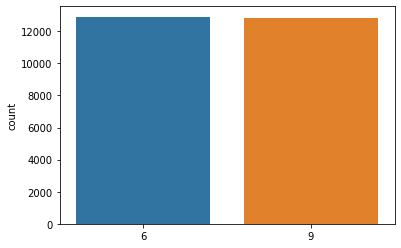

In [32]:
sns.countplot(y_train)

There are similar counts for each digit. This is good as the model will have enough images for each class to train the features for each class. There is no need to downsample or upweigh.

## Check for NaN Values

In [33]:
print(np.isnan(x_train).any())
print(np.isnan(x_test).any())

False
False


## Reshaping

In [34]:
x_train=xxx_train.reshape(xxx_train.shape[0], xxx_train.shape[1],1)
x_test = xxx_test.reshape(xxx_test.shape[0], xxx_test.shape[1],1)

In [35]:
x_train.shape

(25722, 250, 1)

In [36]:
input_shape=x_train.shape
print(input_shape)
output_shape=y_train.shape
print(output_shape)

(25722, 250, 1)
(25722,)


## Label Encoding

Convert categorical labels to one-hot encodings.

E.g., ```2``` is ```[0,0,1,0,0,0,0,0,0,0]``` and ```7``` is ```[0,0,0,0,0,0,0,1,0,0]```.

In [37]:
y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
y_test = tf.one_hot(y_test.astype(np.int32), depth=10)

# CNN

## Define the Model

In [38]:
batch_size = 64
num_classes = 10
epochs = 50

The MaxPool1D filter aims to conserve the main features of the image while reducing the size.

Dropout layers: a percent of random nodes are ignored.

```relu``` returns input value if the input value >= 0, else it returns 0.

Flatten converts the tensors into a 1D vector.

The Dense layers are an ANN. Last layer outputs the probability that an EEG signal is in each class.

These models aims to categorize EEG signals, so it uses ```categorical_crossentropy``` loss function. 

In [39]:
model1 = tf.keras.models.Sequential([

    tf.keras.layers.Conv1D(32, 25, padding='same', activation='relu', input_shape=(250,1)),
    tf.keras.layers.Conv1D(32, 25, padding='same', activation='relu'),
    tf.keras.layers.MaxPool1D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv1D(64, 9, padding='same', activation='relu'),
    tf.keras.layers.Conv1D(64, 9, padding='same', activation='relu'),
    tf.keras.layers.MaxPool1D(strides=(2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [40]:
model2 = tf.keras.models.Sequential([

    tf.keras.layers.Conv1D(32, 16, padding='same', activation='relu', input_shape=(250,1)),
    #tf.keras.layers.Conv1D(64, 16, padding='same', activation='relu'),
    tf.keras.layers.MaxPool1D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv1D(32, 8, padding='same', activation='relu'),
    #tf.keras.layers.Conv1D(64, 8, padding='same', activation='relu'),
    tf.keras.layers.MaxPool1D(strides=(1)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [41]:
# use model1

model = model1

model.compile(optimizer=tf.keras.optimizers.RMSprop(epsilon=1e-08), loss='categorical_crossentropy', metrics=['acc'])

## Fit the Training Data

Stop train after n epochs or training accuracy > threshold.

Next cell defines a CallBack. If xx.x% accuracy is achieved, the model stops training. 

In [42]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')> 0.95): #0.995):
      print("\nReached xx% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [43]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.1,
                    callbacks=[callbacks])

Epoch 1/50
362/362 [==============================] - 13s 33ms/step - loss: 0.6452 - acc: 0.6746 - val_loss: 0.6494 - val_acc: 0.6358
Epoch 2/50
362/362 [==============================] - 12s 34ms/step - loss: 0.4115 - acc: 0.8387 - val_loss: 0.5729 - val_acc: 0.7575
Epoch 3/50
362/362 [==============================] - 12s 34ms/step - loss: 0.3455 - acc: 0.8663 - val_loss: 0.7882 - val_acc: 0.7143
Epoch 4/50
362/362 [==============================] - 13s 35ms/step - loss: 0.3149 - acc: 0.8825 - val_loss: 0.9959 - val_acc: 0.6518
Epoch 5/50
362/362 [==============================] - 13s 35ms/step - loss: 0.2948 - acc: 0.8885 - val_loss: 1.3923 - val_acc: 0.6421
Epoch 6/50
362/362 [==============================] - 12s 33ms/step - loss: 0.2831 - acc: 0.8900 - val_loss: 0.9480 - val_acc: 0.6584
Epoch 7/50
362/362 [==============================] - 12s 34ms/step - loss: 0.2658 - acc: 0.8983 - val_loss: 0.5966 - val_acc: 0.7703
Epoch 8/50
362/362 [==============================] - 12s 34ms

# 4. Evaluate the Model

## Accuracy Curve

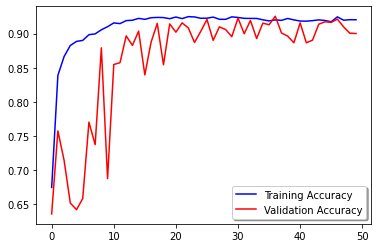

In [47]:
fig, ax = plt.subplots(1,1)
# ax[0].plot(history.history['loss'], color='b', label="Training Loss")
# ax[0].plot(history.history['val_loss'], color='r', label="Validation Loss",axes =ax[0])
# legend = ax[0].legend(loc='best', shadow=True)

ax.plot(history.history['acc'], color='b', label="Training Accuracy")
ax.plot(history.history['val_acc'], color='r',label="Validation Accuracy")
legend = ax.legend(loc='best', shadow=True)

## Predict Results

In [48]:
test_loss, test_acc = model.evaluate(x_test, y_test)

89/89 [==============================] - 0s 3ms/step - loss: 0.2194 - acc: 0.9190


## Confusion Matrix

In [49]:
# Predict the values from the test data.
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert testing observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1)
# compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred_classes) 

<AxesSubplot:>

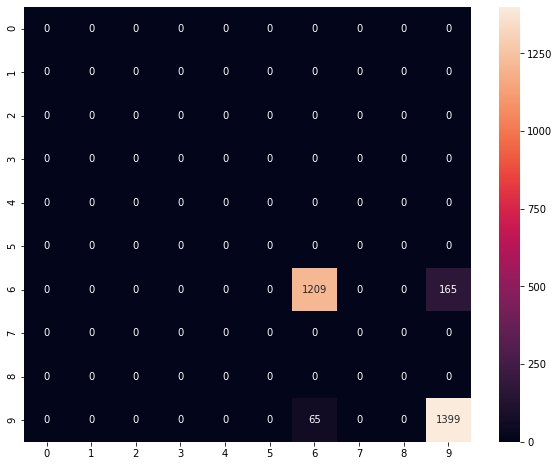

In [50]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='g')